<a href="https://colab.research.google.com/github/exem-ai-isoh/Hands-On-Machine-Learning/blob/master/processing_sequences_using_rnns_anc_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


#Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

Saving figure time_series_plot


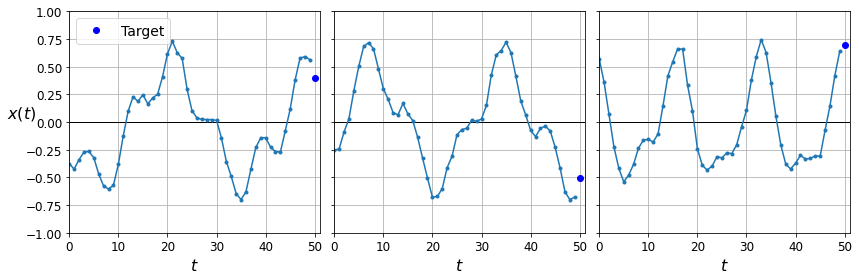

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

# Deep RNNs


In [6]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 17s 57ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0035 - val_l

In [7]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0029


0.002910564886406064

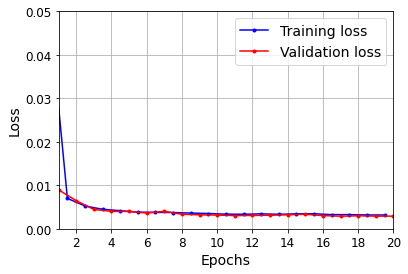

In [8]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

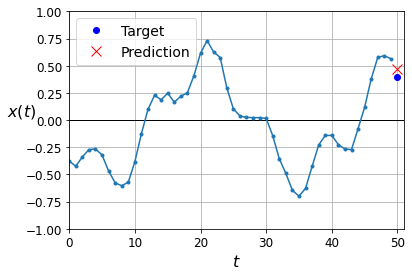

In [9]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

simpleRNN 층은 기본적으로 tanh함수를 사용하기 때문에 예측된 값이 -1과 1사이 범위에 놓입니다. 다른 활성화 함수를 사용하기 위해 출력층을 Dense로 바꾸는 경우가 많습니다. 더 빠르고 정확도는 비슷합니다. 

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # 이제는 두번째 순환층이 마지막이 되었으므로 return_sequence=True를 제거한다.
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0030 - val_lo

In [11]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0026


0.002623623237013817

#Forecasting Several Steps Ahead

방법1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가한다.

In [12]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [13]:
Y_pred.shape

(1, 10, 1)

Saving figure forecast_ahead_plot


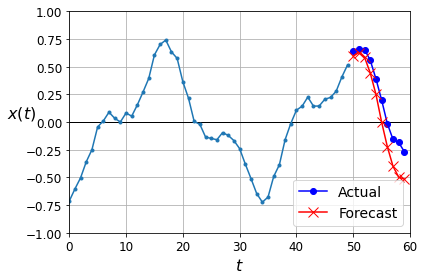

In [14]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

방법2. RNN을 훈련하여 다음 값 10개를 한번에 예측하는 것입니다.

In [15]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0110 - val_lo

In [17]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

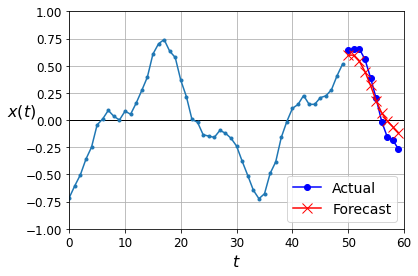

In [18]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [20]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [21]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0325 - last_time_step_mse: 0.0214 - val_loss: 0.0368 - val_last_time_step_mse: 0.0279
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0298 - last_time_step_mse: 0.0188 - val_loss: 0.0273 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0266 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0248 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [==

In [22]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

# S2S 모델로 변환하기 위해 마지막 층에도 return_sequence=True를 지정
# TimeDistributed 층은 다른 층(Dense)을 감싸서 입력 시퀀스의 모든 타임 스텝에 이를 적용합니다.
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 20ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0363 - val_last_time_step_mse: 0.0260
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0325 - last_time_step_mse: 0.0214 - val_loss: 0.0368 - val_last_time_step_mse: 0.0279
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0298 - last_time_step_mse: 0.0188 - val_loss: 0.0273 - val_last_time_step_mse: 0.0155
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0270 - last_time_step_mse: 0.0149 - val_loss: 0.0266 - val_last_time_step_mse: 0.0163
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0250 - last_time_step_mse: 0.0123 - val_loss: 0.0248 - val_last_time_step_mse: 0.0122
Epoch 7/20
219/219 [==

In [24]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

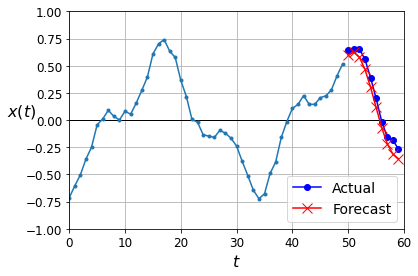

In [25]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# Deep RNNs with Layer Norm

In [26]:
from tensorflow.keras.layers import LayerNormalization

In [27]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 12s 42ms/step - loss: 0.1595 - last_time_step_mse: 0.1549 - val_loss: 0.0711 - val_last_time_step_mse: 0.0646
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0629 - last_time_step_mse: 0.0550 - val_loss: 0.0569 - val_last_time_step_mse: 0.0492
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0534 - last_time_step_mse: 0.0451 - val_loss: 0.0495 - val_last_time_step_mse: 0.0404
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0471 - last_time_step_mse: 0.0381 - val_loss: 0.0458 - val_last_time_step_mse: 0.0378
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0426 - last_time_step_mse: 0.0330 - val_loss: 0.0408 - val_last_time_step_mse: 0.0314
Epoch 6/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0392 - last_time_step_mse: 0.0288 - val_loss: 0.0374 - val_last_time_step_mse: 0.0258
Epoch 7/20
219/219 [=

#LSTM

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 23s 65ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 11s 48ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 10s 48ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 

In [30]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788679391145706, 0.008560794405639172]

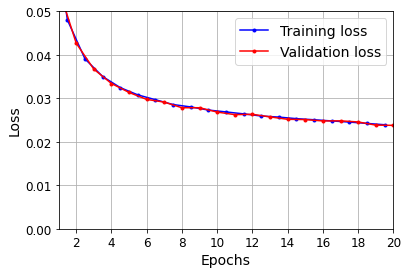

In [31]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [32]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

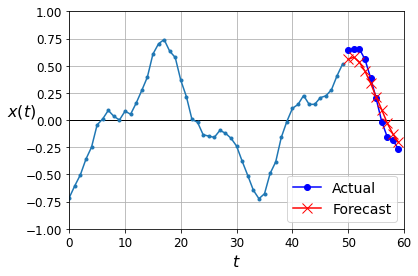

In [33]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()